# Fashion-MNIST Classification with an LDA Head
This notebook trains a small convolutional encoder with a linear discriminant analysis (LDA) head on Fashion-MNIST, then visualises the learned embedding space.


### Setup


In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from src.lda import LDAHead

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

device = cuda


### Data


In [3]:
tfm = transforms.ToTensor()
train_ds = datasets.FashionMNIST(root='./data', train=True, transform=tfm, download=True)
test_ds  = datasets.FashionMNIST(root='./data', train=False, transform=tfm, download=True)
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, pin_memory=True)
test_ld  = DataLoader(test_ds,  batch_size=1024, shuffle=False, num_workers=2, pin_memory=True)
len(train_ds), len(test_ds)

(60000, 10000)

### Model: encoder + LDA head (on-the-fly stats)


In [4]:
class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 64), nn.ReLU(inplace=True),
            nn.Linear(64, dim),
        )
    def forward(self, x): return self.net(x)

class DeepLDA(nn.Module):
    def __init__(self, C, D, ema=0.9):
        super().__init__()
        self.encoder = Encoder(D)
        self.head = LDAHead(C, D, ema, diag_cov=True)
    def forward(self, x, y=None):
        z = self.encoder(x)
        return self.head(z, y)

### Train & Eval


In [5]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ok = tot = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)  # EMA stats
        ok += (logits.argmax(1) == y).sum().item()
        tot += y.size(0)
    return ok / tot

model = DeepLDA(C=10, D=2, ema=0.9).to(device)
opt = torch.optim.Adam(model.encoder.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(1, 21):
    model.train()
    loss_sum = acc_sum = n_sum = 0
    for x, y in train_ld:
        x, y = x.to(device), y.to(device)
        logits = model(x, y)        # uses batch stats + EMA update
        loss = loss_fn(logits, y)
        opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
        with torch.no_grad():
            pred = logits.argmax(1)
            acc_sum += (pred == y).sum().item()
            n_sum += y.size(0)
            loss_sum += loss.item() * y.size(0)
    tr_acc = acc_sum / n_sum
    te_acc = evaluate(model, test_ld)
    print(f"[{epoch:02d}] train loss={loss_sum/n_sum:.4f} acc={tr_acc:.4f} | test acc={te_acc:.4f}")

[01] train loss=0.6342 acc=0.7749 | test acc=0.7922
[02] train loss=0.4665 acc=0.8423 | test acc=0.8017
[03] train loss=0.4217 acc=0.8582 | test acc=0.8276
[04] train loss=0.3858 acc=0.8710 | test acc=0.8491
[05] train loss=0.3646 acc=0.8767 | test acc=0.8380
[06] train loss=0.3444 acc=0.8837 | test acc=0.8393
[07] train loss=0.3282 acc=0.8892 | test acc=0.8451
[08] train loss=0.3113 acc=0.8930 | test acc=0.8575
[09] train loss=0.3042 acc=0.8962 | test acc=0.8525
[10] train loss=0.2916 acc=0.8988 | test acc=0.8637
[11] train loss=0.2812 acc=0.9029 | test acc=0.8599
[12] train loss=0.2711 acc=0.9058 | test acc=0.8523
[13] train loss=0.2642 acc=0.9084 | test acc=0.8471
[14] train loss=0.2596 acc=0.9098 | test acc=0.8726
[15] train loss=0.2488 acc=0.9128 | test acc=0.8641
[16] train loss=0.2439 acc=0.9142 | test acc=0.8691
[17] train loss=0.2356 acc=0.9170 | test acc=0.8715
[18] train loss=0.2313 acc=0.9187 | test acc=0.8637
[19] train loss=0.2311 acc=0.9182 | test acc=0.8627
[20] train l

In [6]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

DeepLDA(
  (encoder): Encoder(
    (net): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=256, bias=True)
      (2): ReLU(inplace=True)
      (3): Linear(in_features=256, out_features=64, bias=True)
      (4): ReLU(inplace=True)
      (5): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (head): LDAHead()
)

### Collect a Small Random Subset of Embeddings


In [7]:
emb_list, y_list = [], []
max_points = int(len(train_ld.dataset) * 0.05)

with torch.no_grad():
    for X, y in train_ld:
        X, y = X.to(device), y.to(device)
        z = model.encoder(X)
        emb_list.append(z)
        y_list.append(y)
        if sum(t.shape[0] for t in emb_list) >= max_points:
            break

Z = torch.cat(emb_list, dim=0).cpu().numpy()[:max_points]
Y = torch.cat(y_list, dim=0).cpu().numpy()[:max_points]

### Inspect Learned Statistics


In [8]:
mu = model.head.mu_ema.detach().cpu()  # (C, K, D) or (C*K, D)

### Visualise Embeddings


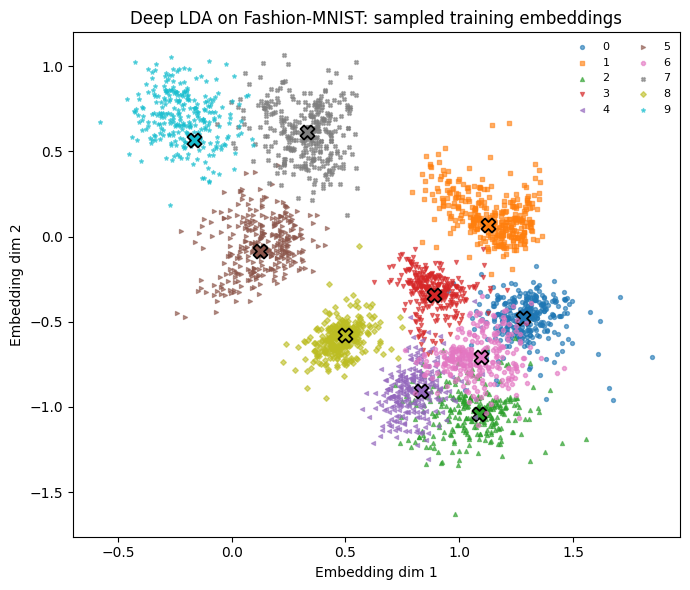

In [9]:
plt.figure(figsize=(7,6))
cmap = plt.get_cmap("tab10", 10)
markers = ['o','s','^','v','<','>','P','X','D','*']

for c in range(10):
    idx = (Y == c)
    plt.scatter(Z[idx,0], Z[idx,1], s=8, alpha=0.6,
                c=[cmap(c)], marker=markers[c], label=f"{c}")
    for k in range(mu.shape[1]):
        m = mu[c]
        plt.scatter(m[0], m[1], s=100, marker='X',
                    c=[cmap(c)], edgecolor='k', linewidths=1.2)

plt.title("Deep LDA on Fashion-MNIST: sampled training embeddings")
plt.xlabel("Embedding dim 1")
plt.ylabel("Embedding dim 2")
plt.legend(fontsize=8, ncol=2, frameon=False)
plt.tight_layout()
plt.show()